In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Normalization, RandomFlip, RandomRotation

# from utils.data_loader import DataLoader

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

class DataLoader:
    def __init__(self, root_path):
        if IN_COLAB:
        	# Mount Google Drive
            drive.mount('/content/drive')
            self.root = '/content/drive/MyDrive/' + root_path
        else:
            self.root = root_path

    def load_image_data(self, path, image_size, batch_size, shuffle):
        data_directory = self.root + path

        dataset = image_dataset_from_directory(
            data_directory,
            image_size=(image_size, image_size),
            batch_size=batch_size,
            shuffle=shuffle
		    )

        return dataset

In [3]:
data_loader = DataLoader('split_data_white_padded')

train_data_path = '/train'
test_data_path = '/test'
validation_data_path = '/validation'

IMAGE_SIZE = 256
BATCH_SIZE = 32
SHUFFLE = True

train_dataset = data_loader.load_image_data(train_data_path, IMAGE_SIZE, BATCH_SIZE, SHUFFLE)
validation_dataset = data_loader.load_image_data(validation_data_path, IMAGE_SIZE, BATCH_SIZE, not SHUFFLE)
test_dataset = data_loader.load_image_data(test_data_path, IMAGE_SIZE, BATCH_SIZE, not SHUFFLE)

Mounted at /content/drive
Found 4121 files belonging to 2 classes.
Found 1154 files belonging to 2 classes.
Found 577 files belonging to 2 classes.


In [5]:
normalization = Normalization(axis=None)

# calculate mean and standard deviation over all training samples and normalize all data
train_images = train_dataset.map(lambda x, y: x)
normalization.adapt(train_images)

In [6]:
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal"))
data_augmentation.add(RandomRotation(0.1))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(dataset, augment=False):
  # Resize and rescale all datasets.
  dataset = dataset.map(lambda x, y: (normalization(x), y),
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    dataset = dataset.map(lambda x, y: (data_augmentation(x), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
train_dataset = preprocess(train_dataset, augment=True)
validation_dataset = preprocess(validation_dataset)

tf.Tensor([1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0], shape=(32,), dtype=int32)


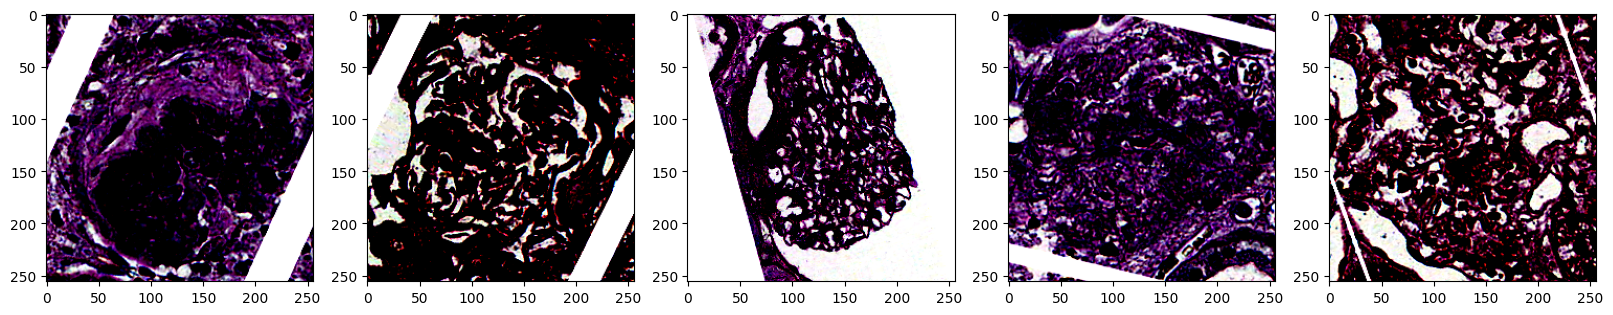

In [9]:
def display(ds):
    images, labels = next(iter(ds.take(5)))
    print(labels)
    fig, ax = plt.subplots(ncols=5, figsize=(20,20))
    for idx, img in enumerate(images[:5]):
        ax[idx].imshow(img.numpy())

display(train_dataset)

In [10]:
simple_cnn_model = Sequential()

simple_cnn_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
simple_cnn_model.add(MaxPooling2D())
simple_cnn_model.add(Conv2D(32, (3,3), 1, activation='relu'))
simple_cnn_model.add(MaxPooling2D())
simple_cnn_model.add(Conv2D(16, (3,3), 1, activation='relu'))
simple_cnn_model.add(MaxPooling2D())
simple_cnn_model.add(Flatten())
simple_cnn_model.add(Dense(256, activation='relu'))
simple_cnn_model.add(Dense(1, activation='sigmoid'))

In [11]:
optimizer = Adam(learning_rate=0.0001)

simple_cnn_model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [12]:
simple_cnn_history = simple_cnn_model.fit(train_dataset, epochs=25, validation_data=validation_dataset)

Epoch 1/25
129/129 [==============================] - 456s 3s/step - loss: 0.2916 - accuracy: 0.8847 - val_loss: 0.2450 - val_accuracy: 0.9012
Epoch 2/25
129/129 [==============================] - 173s 1s/step - loss: 0.1988 - accuracy: 0.9287 - val_loss: 0.2012 - val_accuracy: 0.9272
Epoch 3/25
129/129 [==============================] - 158s 1s/step - loss: 0.1716 - accuracy: 0.9374 - val_loss: 0.2308 - val_accuracy: 0.9142
Epoch 4/25
129/129 [==============================] - 157s 1s/step - loss: 0.1545 - accuracy: 0.9410 - val_loss: 0.1696 - val_accuracy: 0.9359
Epoch 5/25
129/129 [==============================] - 168s 1s/step - loss: 0.1469 - accuracy: 0.9449 - val_loss: 0.1825 - val_accuracy: 0.9333
Epoch 6/25
129/129 [==============================] - 170s 1s/step - loss: 0.1354 - accuracy: 0.9503 - val_loss: 0.1540 - val_accuracy: 0.9419
Epoch 7/25
129/129 [==============================] - 169s 1s/step - loss: 0.1261 - accuracy: 0.9469 - val_loss: 0.1517 - val_accuracy: 0.9428

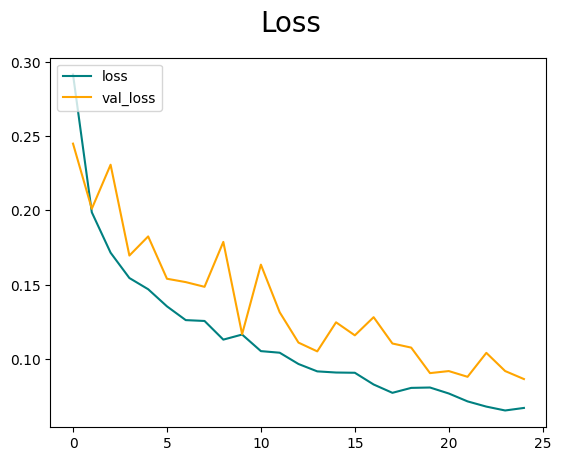

In [13]:
fig = plt.figure()
plt.plot(simple_cnn_history.history['loss'], color='teal', label='loss')
plt.plot(simple_cnn_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

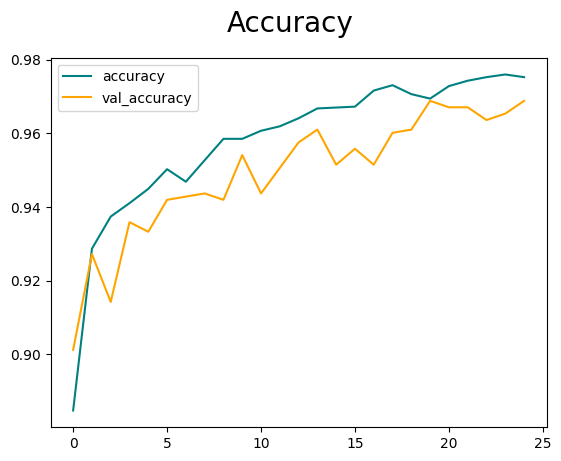

In [14]:
fig = plt.figure()
plt.plot(simple_cnn_history.history['accuracy'], color='teal', label='accuracy')
plt.plot(simple_cnn_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [16]:
test_dataset_normalized = preprocess(test_dataset)

19/19 [==============================] - 147s 8s/step - loss: 0.0954 - accuracy: 0.9705
Test accuracy: 0.9705372452735901
19/19 [==============================] - 13s 619ms/step


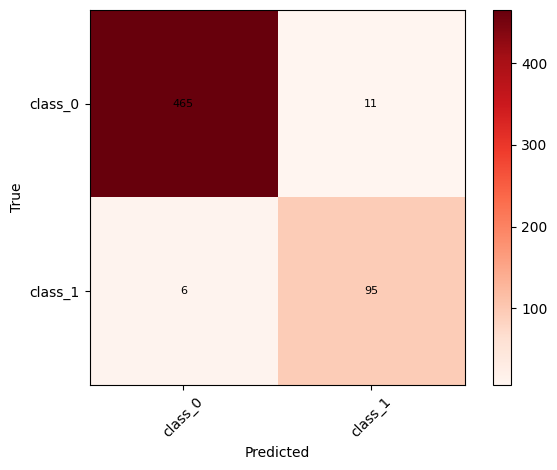

In [17]:
# Evaluate the model
loss, accuracy = simple_cnn_model.evaluate(test_dataset_normalized)
print("Test accuracy:", accuracy)

# Generate predictions for confusion matrix
y_pred = simple_cnn_model.predict(test_dataset_normalized)
y_pred_classes = tf.where(y_pred > 0.5, 1, 0)
y_true = tf.concat([y for _, y in test_dataset], axis=0)

# Calculate and plot confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred_classes)
# Annotate each cell with the corresponding value

plt.imshow(cm, cmap=plt.cm.Reds)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(test_dataset.class_names)), test_dataset.class_names, rotation=45)
plt.yticks(range(len(test_dataset.class_names)), test_dataset.class_names)
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        value = cm[i, j].numpy()
        plt.text(i, j, value, ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()

In [15]:
simple_cnn_model.save("/content/drive/MyDrive/simple_cnn_glomeruli_classifier", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
